In [1]:
# Imports
import os
import yaml
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import Sequence

In [ ]:
class DataGenerator(Sequence):
    def __init__(self, image_files, path='./neuralzome_crate_local/2024-01-31-09-51-48/rgb/', batch_size=16, shuffle=True):
        self.path = path
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.images = image_files
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.images)

    # Data augmentation function
    def augment(self, image, keypoints):
        image = tf.convert_to_tensor(image, dtype=tf.float32)

        h, w = image.shape[:2]
        keypoints = tf.convert_to_tensor(keypoints, dtype=tf.float32)
        keypoints = tf.reshape(keypoints, (4, 2))  # (4, 2) format

        # Random horizontal flip
        if tf.random.uniform([]) > 0.5:
            image = tf.image.flip_left_right(image)
            keypoints = tf.stack([w - keypoints[:, 0], keypoints[:, 1]], axis=1)

        # Random brightness max change is 20%
        image = tf.image.random_brightness(image, max_delta=0.2)

        # Random rotation within ±5 degrees
        angle_rad = tf.random.uniform([], minval=-0.087, maxval=0.087)
        center = tf.constant([w / 2, h / 2], dtype=tf.float32)

        rot_matrix = tf.stack([
            [tf.cos(angle_rad), -tf.sin(angle_rad)],
            [tf.sin(angle_rad), tf.cos(angle_rad)]
        ])

        keypoints = tf.transpose(keypoints - center)
        keypoints = tf.matmul(rot_matrix, keypoints)
        keypoints = tf.transpose(keypoints) + center

        # Random zoom
        zoom_factor = tf.random.uniform([], minval=0.9, maxval=1.0)
        keypoints = (keypoints - center) * zoom_factor + center
        image = tf.image.central_crop(image, central_fraction=zoom_factor)
        image = tf.image.resize(image, (h, w))

        # Reshape back
        keypoints = tf.reshape(keypoints, (8,))

        return image.numpy(), keypoints.numpy()


    def __getitem__(self, index):
        batch_files = self.images[index * self.batch_size:(index + 1) * self.batch_size]
        images = []
        keypoints = []

        for file in batch_files:
            img_path = os.path.join(self.path, file)
            yaml_path = os.path.join(self.path, file.replace('.jpg', '.yaml'))

            img = Image.open(img_path).convert('RGB')
            img = np.array(img).astype('float32') / 255.0

            with open(yaml_path, 'r') as f:
                crate = yaml.safe_load(f)['crates'][0]
            kp = np.array([
                crate['x0'], crate['y0'],
                crate['x1'], crate['y1'],
                crate['x2'], crate['y2'],
                crate['x3'], crate['y3']
            ], dtype='float32')

            img, kp = self.augment(img, kp)

            images.append(img)
            keypoints.append(kp)

        return np.stack(images), np.stack(keypoints)


In [3]:
# Get all valid image files
all_files = []
path = './neuralzome_crate_local/2024-01-31-09-51-48/rgb/'
for file in sorted(os.listdir(path)):
    if file.endswith('.jpg'):
        yaml_path = os.path.join(path, file.replace('.jpg', '.yaml'))
        if os.path.exists(yaml_path):
            with open(yaml_path, 'r') as f:
                data = yaml.safe_load(f)
                if data.get('crates'):
                    all_files.append(file)

# Shuffle and split
np.random.shuffle(all_files)
total = len(all_files)
train_split = int(0.7 * total)
val_split = int(0.9 * total)

train_files = all_files[:train_split]
val_files = all_files[train_split:val_split]
test_files = all_files[val_split:]


In [4]:
train_gen = DataGenerator(train_files, path=path, batch_size=16, shuffle=True)
val_gen = DataGenerator(val_files, path=path, batch_size=16, shuffle=False)
test_gen = DataGenerator(test_files, path=path, batch_size=16, shuffle=False)

In [5]:
# Architecture of the Model - Input shape is (480, 640, 3)

model = models.Sequential([
    layers.Input(shape=(480, 640, 3)),

    layers.Conv2D(36, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2),  # 240x320

    layers.Conv2D(62, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2),  # 120x160

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2),  # 60x80

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2),  # 30x40

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(8)  # 4 corner keypoints so 8 values (x0, y0, x1, y1, x2, y2, x3, y3) as output
])
    

In [6]:
def keypoint_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=keypoint_loss,
    metrics=['mae']
)

history = model.fit(train_gen, validation_data=val_gen, epochs=100)

test_loss, test_mae = model.evaluate(test_gen)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 62s 9s/step - loss: 80913.4922 - mae: 239.4717 - val_loss: 25044.9004 - val_mae: 125.0370
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 47s 8s/step - loss: 25528.9512 - mae: 126.4320 - val_loss: 16823.1543 - val_mae: 103.1352
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 58s 10s/step - loss: 19539.2871 - mae: 110.6869 - val_loss: 15453.9795 - val_mae: 99.9437
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 66s 11s/step - loss: 16902.3945 - mae: 103.4389 - val_loss: 15227.1729 - val_mae: 97.8136
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 59s 10s/step - loss: 16039.8662 - mae: 99.4564 - val_loss: 16867.0332 - val_mae: 102.6690
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 53s 8s/step - loss: 16238.9434 - mae: 103.1310 - val_loss: 13416.1084 - val_mae: 89.7996
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 47s 9s/step - loss: 16414.9062 - mae: 101.3355 - val_loss: 17441.6504 - val_mae: 107.2959
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 7s/step - loss: 18347.4004 - mae: 109.2793 - val_loss: 13433.6279 - val

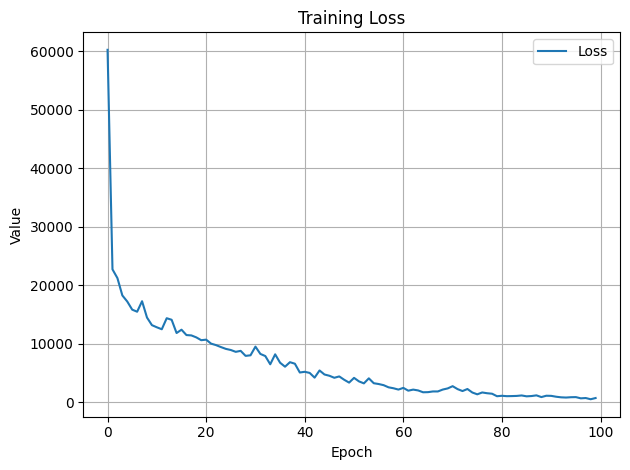

In [7]:
plt.figure()
plt.plot(history.history['loss'], label='Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

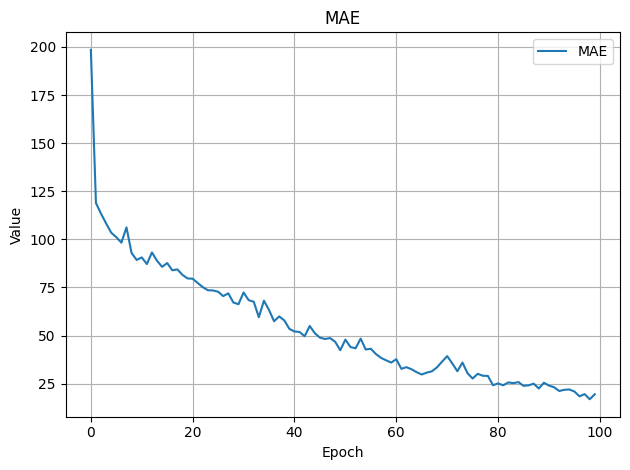

In [8]:
plt.figure()
plt.plot(history.history['mae'], label='MAE')
plt.title('MAE')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

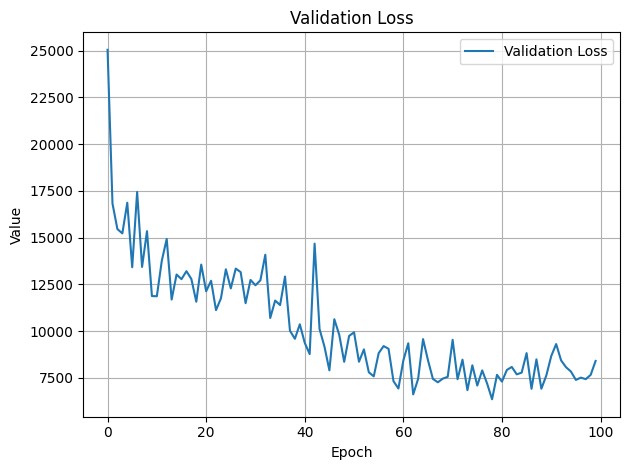

In [9]:
plt.figure()
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

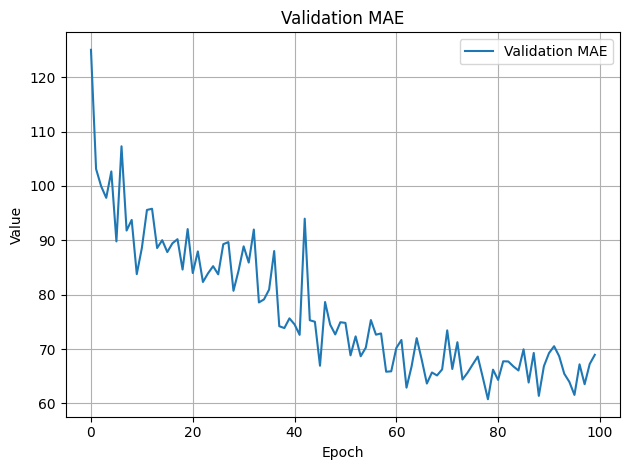

In [10]:
plt.figure()
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()